In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import muon as mu

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import deconvatac as dv

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Load RNA

In [6]:
adata_rna = sc.read("/vol/storage/data/cellxgene/human_cardiac_niches/Global_raw.h5ad", backed="r")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [7]:
adata_rna

AnnData object with n_obs × n_vars = 704296 × 32732 backed at '/vol/storage/data/cellxgene/human_cardiac_niches/Global_raw.h5ad'
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nucl

## Load ATAC

In [8]:
adata_atac = sc.read("/vol/storage/data/cellxgene/human_cardiac_niches/Adult_Peaks.h5ad")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [9]:
#check if peaks contain fragments or reads (more 2s than 1s)
print((adata_atac.X == 2).sum())
print((adata_atac.X == 1).sum())

480957810
336542902


### Process ATAC

In [10]:
dv.pp.reads_to_fragments(adata_atac)

In [11]:
adata_atac.X = adata_atac.layers["fragments"].copy()

<139835x429828 sparse matrix of type '<class 'numpy.float32'>'
	with 901427612 stored elements in Compressed Sparse Row format>

In [12]:
dv.pp.highly_variable_peaks(adata_atac, cluster_key="cell_type")

In [7]:
dv.pp.highly_accessible_peaks(adata_atac)

 TFIDf normalization

In [ ]:
mu.atac.pp.tfidf(adata_atac, to_layer='tfidf_normalized')

Log normalization

In [8]:
adata_atac.layers["counts"] = adata_atac.X.copy()

In [9]:
sc.pp.normalize_total(adata_atac)
sc.pp.log1p(adata_atac)

In [10]:
6

6

In [11]:
adata_atac.layers["log_norm"] = adata_atac.X.copy()
adata_atac.X = adata_atac.layers["counts"].copy()
adata_atac.layers.pop("counts")

<139835x429828 sparse matrix of type '<class 'numpy.float32'>'
	with 901427612 stored elements in Compressed Sparse Row format>

In [12]:
adata_atac

AnnData object with n_obs × n_vars = 139835 × 429828
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
    var: 'highly_variable', 'highly_accessible'
    uns: 'log1p'
    layers: 'tfidf_normalized', 'log_norm'

## Process RNA data

In [ ]:
# not all cells are from multiome data
adata_rna = adata_rna[adata_rna.obs_names.isin(adata_atac.obs_names)]
adata_rna = adata_rna.to_memory()

In [ ]:
adata_rna

In [ ]:
adata_rna.layers["counts"] = adata_rna.X.copy()

In [ ]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)

sc.pp.highly_variable_genes(adata_rna, n_top_genes=4000)

In [ ]:
adata_rna.layers["log_norm"] = adata_rna.X.copy()
adata_rna.X = adata_rna.layers["counts"].copy()
adata_rna.layers.pop("counts")

## Combine into mudata

In [16]:
mdata = mu.MuData({"atac": adata_atac, "rna": adata_rna})

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


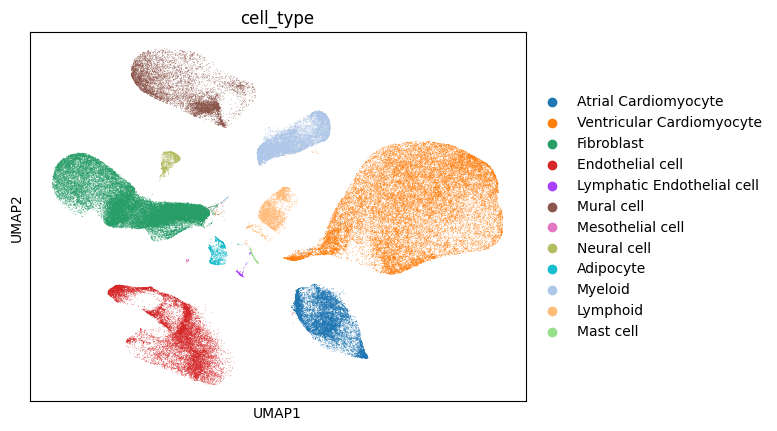

In [17]:
sc.pl.umap(mdata["rna"], color="cell_type")

In [18]:
mdata.write("/vol/storage/data/cellxgene/human_cardiac_niches/human_cardiac_niches.h5mu")

: 

In [5]:
mdata = mu.read("/vol/storage/data/cellxgene/human_cardiac_niches/human_cardiac_niches.h5mu")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
mdata

MuData object with n_obs × n_vars = 139835 × 462560
  var:	'highly_variable'
  2 modalities
    atac:	139835 x 429828
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
      var:	'highly_variable', 'highly_accessible'
      layers:	'tfidf_normalized'
    rna:	139835 x 32732
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
      var:	'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facility_colors', 'flushed_colors', 'gender_colors', 'hvg', 'kit_10x_colors', 'leiden', 'log1p', 'modality_colors', 'neighbors', 'original_or_new_colors', 'region_colors', 'region_finest_colors', 'scANVI_predictions_colors', 'umap'
      obsm:	'X_scArches', 'X_umap'
      layers:	'log_norm'
      obsp:	'connectivities', 'distances'

In [7]:
adata_atac = mdata.mod['atac']
adata_rna = mdata.mod['rna']